# 24 Plotting Hypocenters of Earthquakes with PyVista

Hypocenters of earthquake can be nicely visualized using GemGIS and PyVista.

<img src="../images/tutorial24_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import gemgis as gg

file_path ='data/24_plotting_hypocenters_of_earthquakes/'

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
gg.download_gemgis_data.download_tutorial_data(filename="24_plotting_hypocenters_of_earthquakes.zip", dirpath=file_path)

## Load Earthquake Data

The data used here was obtained from the earthquake catalog of the Earthquake Station of the University of Cologne in Bensberg (http://www.seismo.uni-koeln.de/catalog/index.htm) 

## Converting Pandas DataFrame to GeoDataFrame and reproject coordinates

In [3]:
import geopandas as gpd
gdf = gpd.read_file(filename= file_path+'earthquake_data.shp')

In [4]:
#gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.X, data.Y), crs='EPSG:4326').to_crs('EPSG:4647').reset_index()

gdf = gg.vector.extract_xy(gdf=gdf, reset_index=True)
gdf.head()

,Y,X,Z,RASTERVALU,Tiefe [km],Magnitude,Epizentrum,Year,geometry
0,5645741.63,32322660.15,-8249.25,150.75,8.40,1.50,STETTERNICH,2002,POINT (32322660.151 5645741.630)
1,5645947.18,32323159.51,89.63,89.63,0.00,0.80,SOPHIENHOEHE,2014,POINT (32323159.505 5645947.183)
2,5637979.08,32306261.57,-14056.14,143.86,14.20,2.20,ALSDORF,2007,POINT (32306261.571 5637979.080)
3,5645345.19,32321239.77,-8124.22,275.78,8.40,1.70,STETTERNICH,1999,POINT (32321239.770 5645345.189)
4,5645698.15,32320689.25,-5329.58,270.42,5.60,1.90,STETTERNICH,1999,POINT (32320689.249 5645698.148)


## Loading WMS Data for Plotting

In [5]:
wms = gg.web.load_wms(url='https://ows.terrestris.de/osm/service?')

In [6]:
wms_map = gg.web.load_as_array(url=wms.url,
                               layer='OSM-WMS', 
                               style='default', 
                               crs='EPSG:4647', 
                               bbox=[32286000,32328000, 5620000,5648000],
                               size=[4200, 2800], 
                               filetype='image/png')

## Plotting the data

<AxesSubplot:>

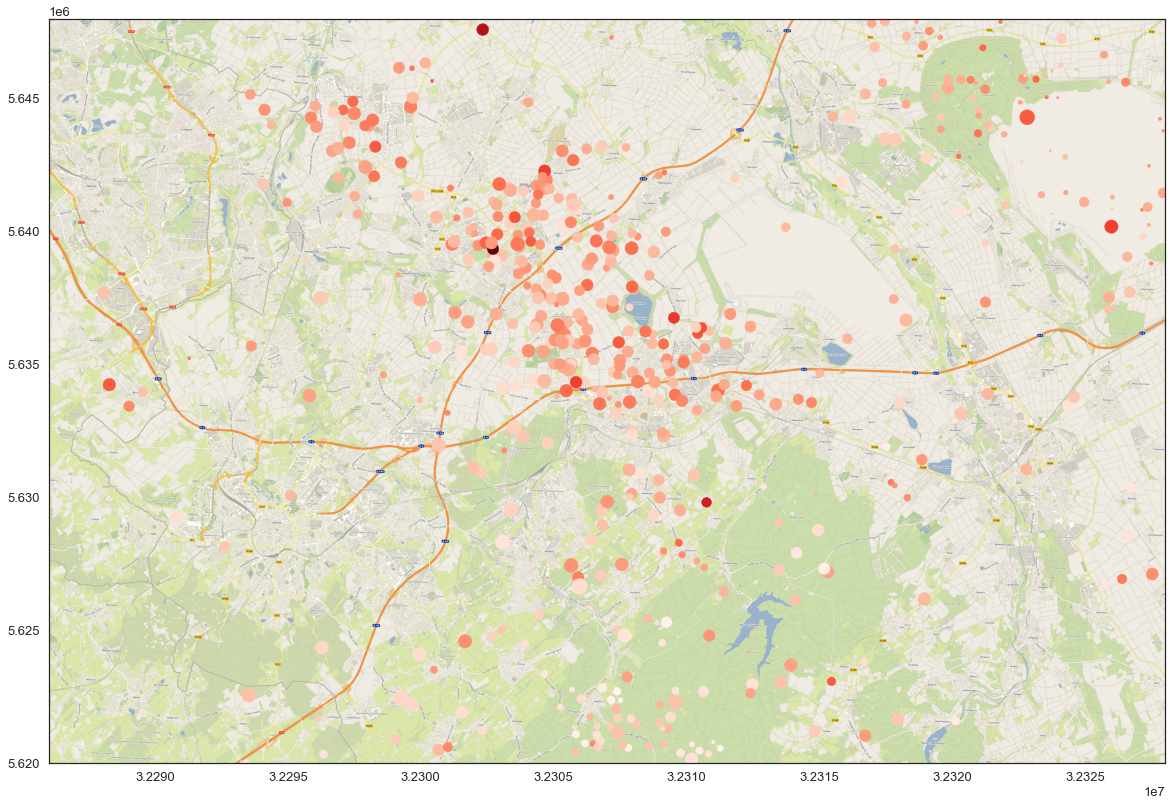

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(20,20))

ax.imshow(wms_map, extent=[32286000,32328000, 5620000,5648000])
gdf.plot(ax=ax, aspect='equal', column='Magnitude', cmap='Reds', markersize = gdf['Tiefe [km]'].values*10)

## Create PyVista Spheres

In [8]:
import pyvista as pv

test = pv.Sphere(radius=1000, center=gdf.loc[0][['X', 'Y', 'Z']].tolist())
test

PolyData (0x2cbf6ba3fa0)
  N Cells:	1680
  N Points:	842
  X Bounds:	3.232e+07, 3.232e+07
  Y Bounds:	5.645e+06, 5.647e+06
  Z Bounds:	-9.249e+03, -7.249e+03
  N Arrays:	1

In [9]:
import numpy as np

spheres = pv.MultiBlock([pv.Sphere(radius=gdf.loc[i]['Magnitude']*200, center=gdf.loc[i][['X', 'Y', 'Z']].tolist()) for i in range(len(gdf))])

for i in range(len(spheres.keys())):
    spheres[spheres.keys()[i]]['Magnitude'] = np.zeros(len(spheres[spheres.keys()[i]].points)) + gdf.loc[i]['Magnitude']
    spheres[spheres.keys()[i]]['Year'] = np.zeros(len(spheres[spheres.keys()[i]].points)) + gdf.loc[i]['Year']

In [10]:
type(spheres)

pyvista.core.composite.MultiBlock

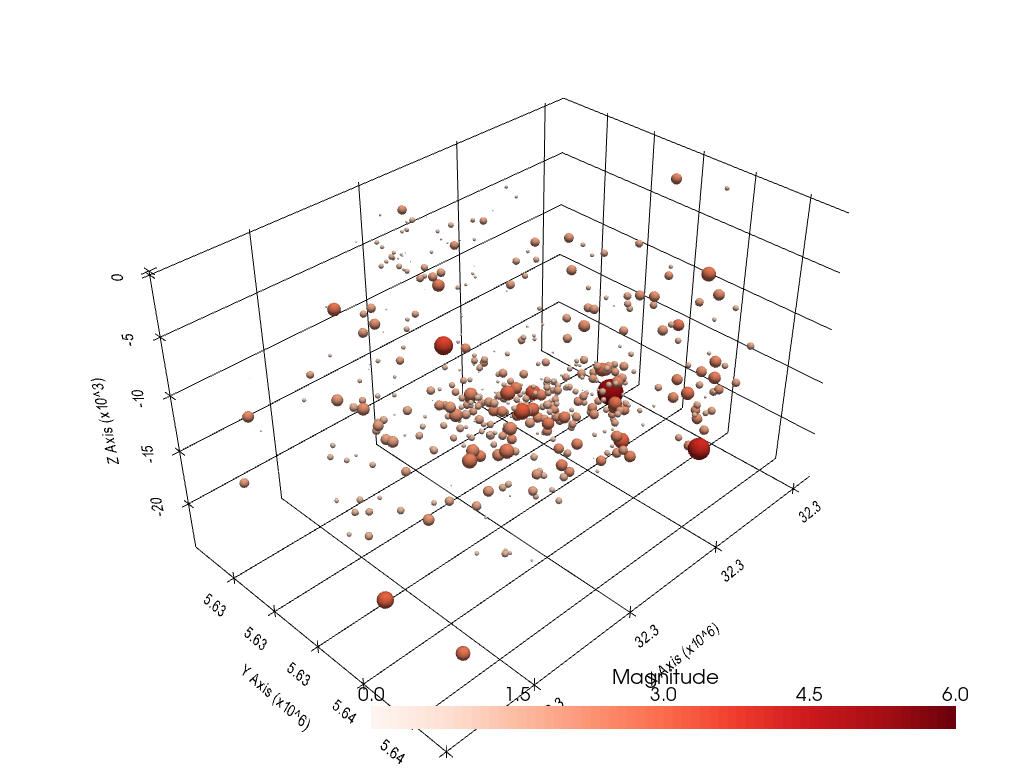

In [11]:
sargs = dict(fmt="%.1f", color='black')

p = pv.Plotter(notebook=True)

p.add_mesh(spheres,scalars='Magnitude', cmap='Reds', clim=[0,6], scalar_bar_args=sargs)

p.set_background('white')
p.show_grid(color='black')
p.show()

The above shown steps are also combined in the function ``create_meshes_hypocenters(..)``.

In [12]:
spheres = gg.visualization.create_meshes_hypocenters(gdf=gdf)
spheres

MultiBlock (0x2cbf4b818e0)
  N Blocks:	497
  X Bounds:	32287780.000, 32328260.000
  Y Bounds:	5620074.000, 5648385.000
  Z Bounds:	-24317.020, 309.130

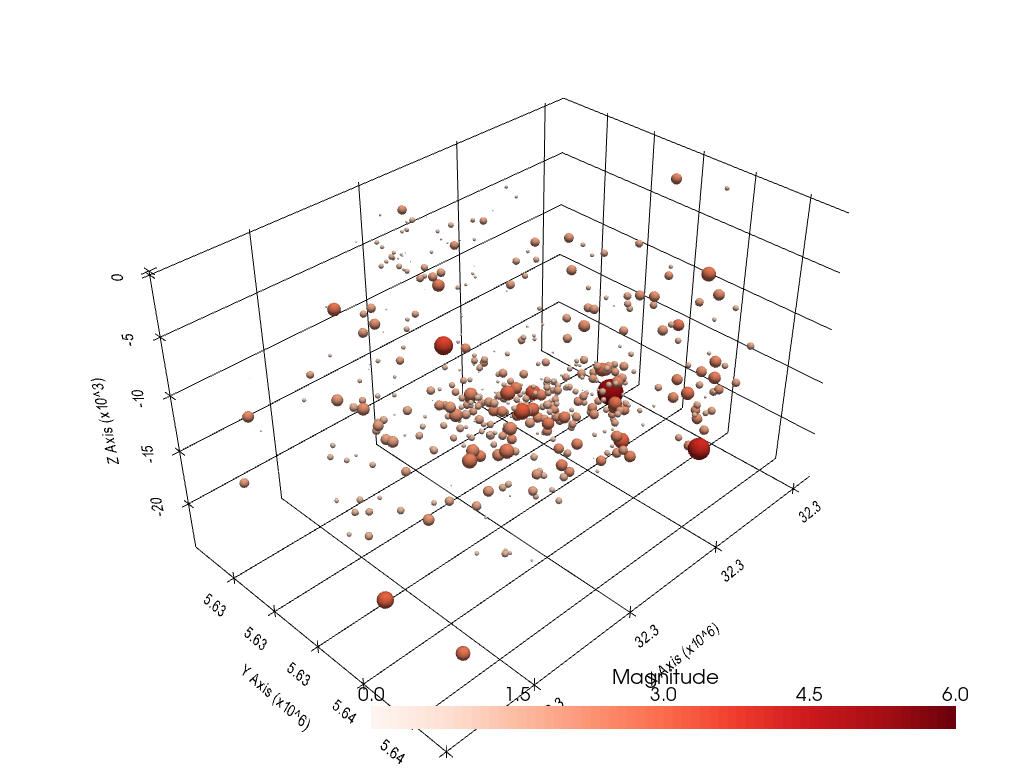

In [13]:
sargs = dict(fmt="%.1f", color='black')

p = pv.Plotter(notebook=True)

p.add_mesh(spheres,scalars='Magnitude', cmap='Reds', clim=[0,6], scalar_bar_args=sargs)

p.set_background('white')
p.show_grid(color='black')
p.show()

## TODO: Create Plot to visualize data as time series